# 2. Mean-Variance Optimization
Group members: Shen-Ching Feng, Dhruv Kohli, Scott Hanna, Tanwir Silar

### 1. Summary Statistics
- Calculate and display the mean and volatility of each asset’s excess return. (Recall we use volatility to refer to standard deviation.)
- Which assets have the best and worst Sharpe ratios?

In [2]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import *

In [3]:
priceData = pd.read_excel("../data/multi_asset_etf_data.xlsx", sheet_name = "prices").set_index("Date")
totalReturnData = pd.read_excel("../data/multi_asset_etf_data.xlsx", sheet_name = "total returns").set_index("Date")
excessReturnData = pd.read_excel("../data/multi_asset_etf_data.xlsx", sheet_name = "excess returns").set_index("Date")

priceData.drop(columns = ["QAI"], inplace = True)
totalReturnData.drop(columns = ["QAI"], inplace = True)
excessReturnData.drop(columns = ["QAI"], inplace = True)

In [4]:
mean, vol = list(), list()

for ticker in excessReturnData.columns:
    mean.append(excessReturnData[ticker].mean() * 12)
    vol.append(excessReturnData[ticker].std() * np.sqrt(12))

sharpe = [m / v for m, v in zip(mean, vol)]
result = pd.DataFrame({'Ticker': excessReturnData.columns, 'Mean': mean, 'Volatility': vol, 'Sharpe': sharpe})
print(result)

  Ticker      Mean  Volatility    Sharpe
0    BWX -0.007716    0.082789 -0.093202
1    DBC -0.005292    0.166553 -0.031774
2    EEM  0.029339    0.176164  0.166542
3    EFA  0.061775    0.150903  0.409372
4    HYG  0.041371    0.075928  0.544873
5    IEF  0.016404    0.063442  0.258569
6    IYR  0.074916    0.168675  0.444143
7    PSP  0.092561    0.213370  0.433804
8    SPY  0.128141    0.142839  0.897103
9    TIP  0.020502    0.051115  0.401091


- SPY has the highest sharpe ratio of 0.897
- BWX has the worst sharpe ratio of -0.093

---

### 2. Descriptive Analysis
- Calculate the correlation matrix of the returns. Which pair has the highest correlation? And the lowest?
- How well have TIPS done in our sample? Have they outperformed domestic bonds? Foreign bonds?

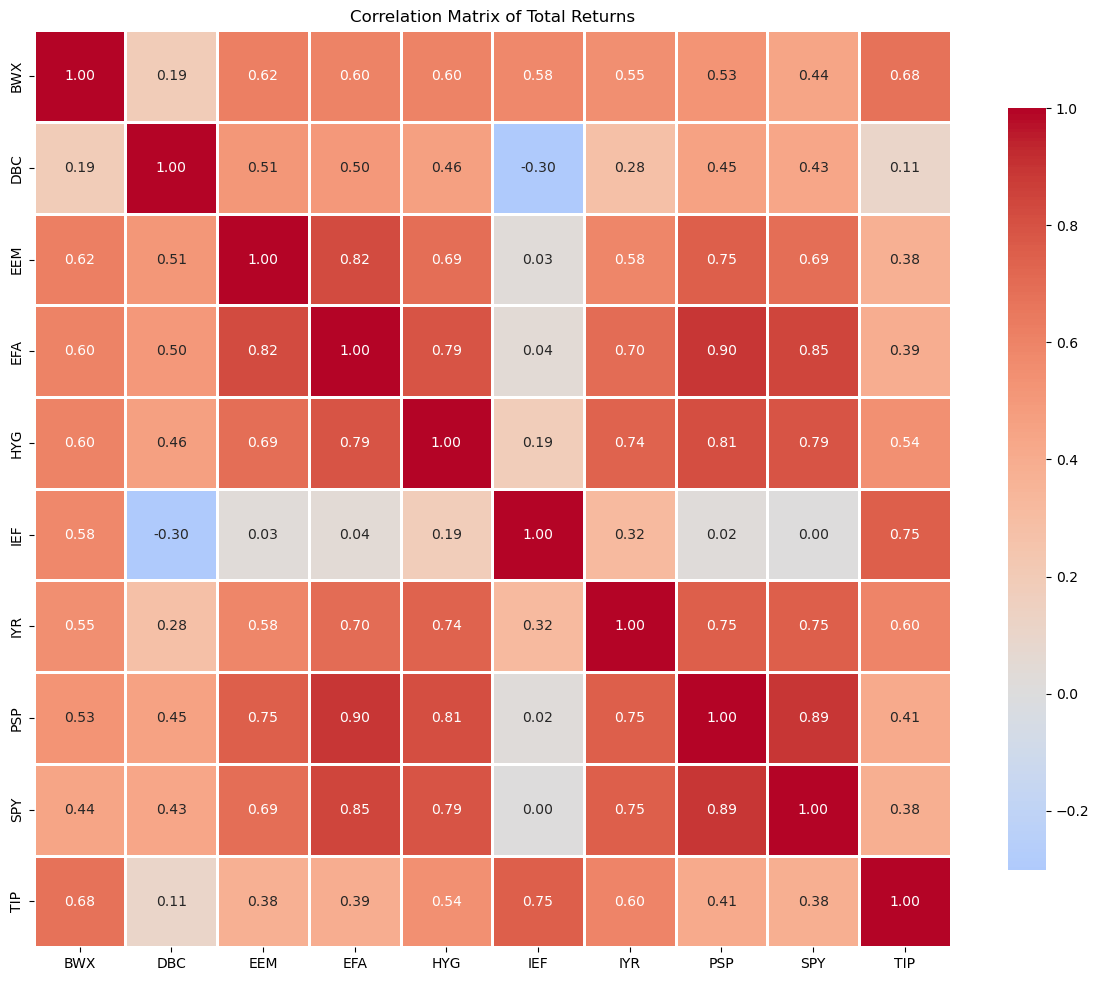

In [5]:
corr_matrix = excessReturnData.corr()

plt.figure(figsize = (12, 10))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', cmap = 'coolwarm', center = 0, 
            square = True, linewidths = 1, cbar_kws = {"shrink": 0.8})
plt.title('Correlation Matrix of Total Returns')
plt.tight_layout()
plt.show()
# Plot_CorrHeatmap(excessReturnData)

- Lowest correlation pairs
  - (SPY, IEF) with correlation of 0.00
  - (PSP, IEF) with correlation of 0.02
- Highest correlation pairs
  - (PSP, EFA) with correlation of 0.90
  - (PSP, SPY) with correlation of 0.89

TIPS has a high Sharpe ratio of 0.4. Its average excess return is 2.05%, which is higher than domestic bonds (1.64%) and foreign bonds (-0.77%). It has low return, but accompanied with low volatility of 5.11%. Overall, TIPS has done well in our sample.

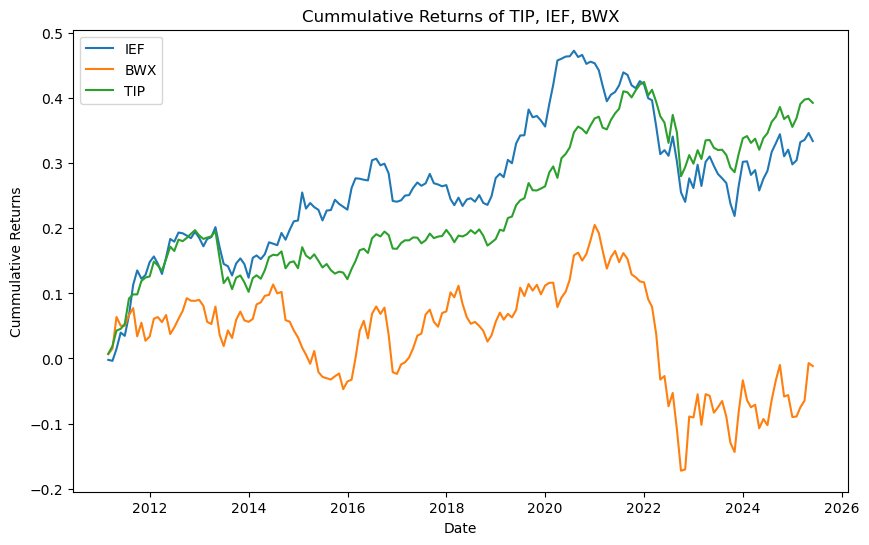

In [6]:
IEFreturn, BWXreturn, TIPreturn = [0], [0], [0]

for ief, bwx, tip in zip(totalReturnData['IEF'], totalReturnData['BWX'], totalReturnData['TIP']):
    IEFreturn.append(ief + IEFreturn[-1])
    BWXreturn.append(bwx + BWXreturn[-1])
    TIPreturn.append(tip + TIPreturn[-1])
    
plt.figure(figsize = (10, 6))
plt.plot(totalReturnData.index, IEFreturn[1:], label = 'IEF')
plt.plot(totalReturnData.index, BWXreturn[1:], label = 'BWX')
plt.plot(totalReturnData.index, TIPreturn[1:], label = 'TIP')
plt.title('Cummulative Returns of TIP, IEF, BWX')
plt.ylabel('Cummulative Returns')
plt.xlabel('Date')
plt.legend()
plt.show()

---

### 3. The MV frontier.
- Compute and display the weights of the tangency portfolios: $$w_{tan} = \delta_{tan}\Sigma^{-1}\~\mu$$

- Does the ranking of weights align with the ranking of Sharpe ratios?
- Compute the mean, volatility, and Sharpe ratio for the tangency portfolio corresponding to $w_{tan}$.

In [7]:
# Calculate Tangency Weights

def CalcTangencyWeights(returns):
    covMat = returns.cov() * 12 # covariance matrix * annual factor
    covInv = np.linalg.inv(covMat) # Sigma^(-1)
    mu = returns.mean() * 12    # mean return vector * auunal factor
    scaling = 1 / (np.transpose(np.ones(len(returns.columns))) @ covInv @ mu)
    tangencyWeights = scaling * (covInv @ mu)
    return tangencyWeights

weights = CalcTangencyWeights(excessReturnData)
tangencyWeights = pd.DataFrame({
    "Asset": excessReturnData.columns,
    "Sharpe": result["Sharpe"],
    "Weights": weights
})
print(tangencyWeights.sort_values(by = "Sharpe", ascending = False))
print("\nSum of weights:", tangencyWeights['Weights'].sum())

  Asset    Sharpe   Weights
8   SPY  0.897103  1.059632
4   HYG  0.544873  0.290614
6   IYR  0.444143 -0.246582
7   PSP  0.433804 -0.332995
3   EFA  0.409372  0.068682
9   TIP  0.401091  0.175293
5   IEF  0.258569  0.881186
2   EEM  0.166542  0.026437
1   DBC -0.031774 -0.071623
0   BWX -0.093202 -0.850643

Sum of weights: 0.9999999999999997


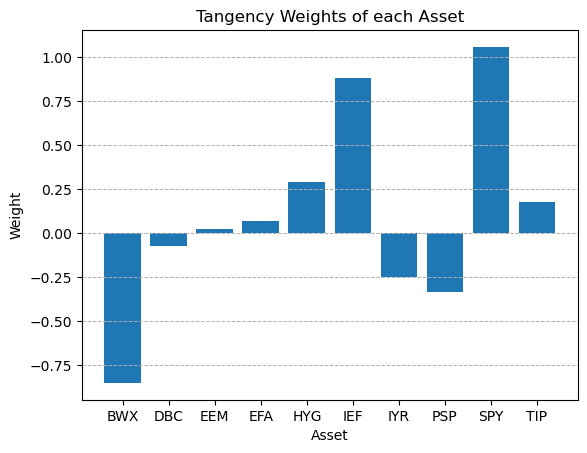

In [8]:
def TangencyWeightsPlot(weights):
    plt.bar(x = weights["Asset"], height = weights["Weights"])
    plt.title("Tangency Weights of each Asset")
    plt.ylabel("Weight")
    plt.xlabel("Asset")
    plt.grid(linestyle = '--', linewidth = 0.7, axis = 'y')
    plt.show()
    
TangencyWeightsPlot(tangencyWeights)

In [9]:
def CalcTangencyPortfolio(returns, portfolioWeights):
    portfolioReturn = returns @ portfolioWeights
    meanReturn = portfolioReturn.mean() * 12
    stdReturn = portfolioReturn.std() * np.sqrt(12)
    portfolioSharpe = meanReturn / stdReturn
    tangencyResult = pd.DataFrame({
        "Portfolio Mean": [meanReturn],
        "Portfolio STD": [stdReturn],
        "Portfolio Sharpe": [portfolioSharpe]
    })
    return tangencyResult

tangencyResult = CalcTangencyPortfolio(excessReturnData, weights)
print(tangencyResult)

   Portfolio Mean  Portfolio STD  Portfolio Sharpe
0         0.12852       0.087477           1.46919


---

### 4. TIPS
Assess how much the tangency portfolio (and performance) change if…

- TIPS are dropped completely from the investment set.

- The expected excess return to TIPS is adjusted to be 0.0012 higher than what the historic sample shows.

Based on the analysis, do TIPS seem to expand the investment opportunity set, implying that Harvard should consider them as a separate asset?

In [10]:
excessReturnWithoutTIP = excessReturnData.drop(columns = ["TIP"])
weightsWithoutTIP = CalcTangencyWeights(excessReturnWithoutTIP)
tangencyWeightsWithoutTIP = pd.DataFrame({
    "Asset": excessReturnWithoutTIP.columns,
    "Weights": weightsWithoutTIP
})
print(tangencyWeightsWithoutTIP)
print("\nSum of weights:", tangencyWeightsWithoutTIP['Weights'].sum())

  Asset   Weights
0   BWX -0.879292
1   DBC -0.063742
2   EEM  0.032493
3   EFA  0.060153
4   HYG  0.316300
5   IEF  1.019957
6   IYR -0.247445
7   PSP -0.339398
8   SPY  1.100973

Sum of weights: 0.9999999999999997


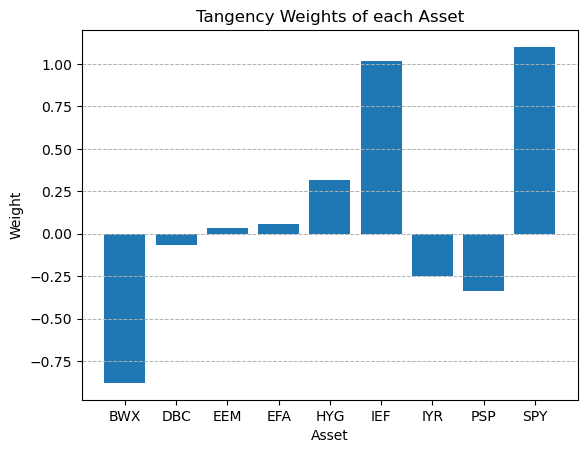

In [11]:
TangencyWeightsPlot(tangencyWeightsWithoutTIP)

In [12]:
excessReturnModTIP = excessReturnData.copy()
excessReturnModTIP["TIP"] = excessReturnModTIP["TIP"] + 0.0012

weightsModTIP = CalcTangencyWeights(excessReturnModTIP)
tangencyWeightsModTIP = pd.DataFrame({
    "Asset": excessReturnModTIP.columns,
    "Weights": weightsModTIP
})

print(tangencyWeightsModTIP)
print("\nSum of weights:", tangencyWeightsModTIP['Weights'].sum())

  Asset   Weights
0   BWX -0.669693
1   DBC -0.121397
2   EEM -0.011815
3   EFA  0.122554
4   HYG  0.128372
5   IEF  0.004667
6   IYR -0.241132
7   PSP -0.292555
8   SPY  0.798513
9   TIP  1.282487

Sum of weights: 0.9999999999999999


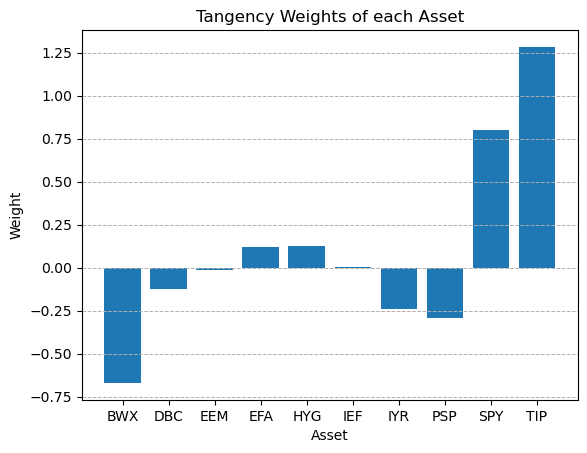

In [13]:
TangencyWeightsPlot(tangencyWeightsModTIP)

In [14]:
tangencyResultWithoutTIP = CalcTangencyPortfolio(excessReturnWithoutTIP, weightsWithoutTIP)
tangencyResultModTIP = CalcTangencyPortfolio(excessReturnModTIP, weightsModTIP)
weightsWithoutTIP = np.append(weightsWithoutTIP, 0)

summary = pd.DataFrame({
    "Asset": excessReturnData.columns,
    "Weights": weights,
    "Weights (Mod TIP)": weightsModTIP,
    "Weights w/o TIP": weightsWithoutTIP
})

print("Tangency Weights")
print(summary)
print("")
print("W/ TIPS")
print(tangencyResult)
print("")
print("TIPS return + 0.0012")
print(tangencyResultModTIP)
print("")
print("W/o TIPS")
print(tangencyResultWithoutTIP)

Tangency Weights
  Asset   Weights  Weights (Mod TIP)  Weights w/o TIP
0   BWX -0.850643          -0.669693        -0.879292
1   DBC -0.071623          -0.121397        -0.063742
2   EEM  0.026437          -0.011815         0.032493
3   EFA  0.068682           0.122554         0.060153
4   HYG  0.290614           0.128372         0.316300
5   IEF  0.881186           0.004667         1.019957
6   IYR -0.246582          -0.241132        -0.247445
7   PSP -0.332995          -0.292555        -0.339398
8   SPY  1.059632           0.798513         1.100973
9   TIP  0.175293           1.282487         0.000000

W/ TIPS
   Portfolio Mean  Portfolio STD  Portfolio Sharpe
0         0.12852       0.087477           1.46919

TIPS return + 0.0012
   Portfolio Mean  Portfolio STD  Portfolio Sharpe
0        0.120361       0.074648          1.612396

W/o TIPS
   Portfolio Mean  Portfolio STD  Portfolio Sharpe
0        0.132736       0.090452          1.467474


TIPS return + 0.0012:
- Weight of TIPS increases from 0.175 to 1.282
- Lower Mean
- Lower STD
- Higher Sharpe Ratio

Without TIPS:
- Higher Mean
- Higher STD
- Lower Sharpe Ratio

---

# 3. Allocations
- Continue with the same data file as the previous section.

- Suppose the investor has a targeted mean excess return (per month) of $\~\mu^{port} = 0.01$

Build the following portfolios:

### Equally weighted portfolio
Rescale the entire weighting vector to have target mean $\~\mu^{port}$. Thus, the $i^{th}$ element of the weight vector is,

$$
w_i^{EW} = \frac{1}{n}
$$

In [15]:
def CalcLeverageRatio(returns: pd.DataFrame, weights, targetReturn: float) -> float:
    ## Monthly Return of portfolio
    monthlyReturn = returns @ weights
    monthlyReturnMean = monthlyReturn.mean()
    
    ## Calc Leverage Ratio to meet Target Return
    leverage = targetReturn / monthlyReturnMean
    return leverage

def CalcMeanStdSharpe(returns, weights) -> tuple:
    monthlyReturn = returns @ weights
    mean = monthlyReturn.mean()
    std = monthlyReturn.std()
    sharpe = mean / std
    return (mean, std, round(sharpe, 4))

def GenerateAllocationReport(returns: pd.DataFrame,
                             initialWeights, 
                             targetReturn: float = 0.01):
    
    leverageRatio = CalcLeverageRatio(returns, initialWeights, targetReturn)
    finalWeight = leverageRatio * initialWeights
    mean, std, sharpe = CalcMeanStdSharpe(returns, finalWeight)
    
    monthlyReturnDF = pd.DataFrame({
        "Date": returns.index,
        "Monthly Return w/o Leverage": returns @ initialWeights,
        "Monthly Return w/ Leverage": returns @ finalWeight
    }).set_index("Date")
    
    print(monthlyReturnDF)
    print(f"\nLeverage Ratio: {round(leverageRatio, 4)}")
    print(f"Monthly Return Mean: {round(mean, 4)}; STD: {round(std, 4)}; Sharpe: {round(sharpe, 4)}")
    return finalWeight

In [16]:
# Equally Weighted Portfolio

targetReturn = 0.01
numAsset = len(excessReturnData.columns)
weightsEqual = np.array([1/numAsset for _ in range(numAsset)])

finalWeightEW = GenerateAllocationReport(excessReturnData, weightsEqual)

            Monthly Return w/o Leverage  Monthly Return w/ Leverage
Date                                                               
2011-02-28                     0.022705                    0.060279
2011-03-31                     0.009393                    0.024938
2011-04-30                     0.036994                    0.098214
2011-05-31                    -0.012433                   -0.033008
2011-06-30                    -0.015464                   -0.041056
...                                 ...                         ...
2025-01-31                     0.021397                    0.056806
2025-02-28                     0.007454                    0.019789
2025-03-31                    -0.012274                   -0.032585
2025-04-30                    -0.004370                   -0.011602
2025-05-31                     0.018699                    0.049643

[172 rows x 2 columns]

Leverage Ratio: 2.6549
Monthly Return Mean: 0.01; STD: 0.0777; Sharpe: 0.1287


### Risk-parity (RP)

Risk-parity is a term used in a variety of ways, but here we have in mind setting the weight of the portfolio to be proportional to the inverse of its full-sample variance estimate. Thus, the $i^{th}$ element of the weight vector is,

$$
w_i^{RP} = \frac{1}{\sigma_i^2}
$$

where $\sigma_i^2$ is the full-sample variance estimate of asset $i$.

In [17]:
# Risk Parity Portfolio

targetReturn = 0.01
weightsRP = np.array([std**2 / (result["Volatility"]**2).sum() for std in result["Volatility"]])

finalWeightRP = GenerateAllocationReport(excessReturnData, weightsRP)

            Monthly Return w/o Leverage  Monthly Return w/ Leverage
Date                                                               
2011-02-28                     0.030704                    0.062887
2011-03-31                     0.014062                    0.028801
2011-04-30                     0.043733                    0.089572
2011-05-31                    -0.023274                   -0.047669
2011-06-30                    -0.025031                   -0.051269
...                                 ...                         ...
2025-01-31                     0.031981                    0.065504
2025-02-28                    -0.000671                   -0.001374
2025-03-31                    -0.020811                   -0.042625
2025-04-30                    -0.013999                   -0.028672
2025-05-31                     0.029747                    0.060927

[172 rows x 2 columns]

Leverage Ratio: 2.0482
Monthly Return Mean: 0.01; STD: 0.0825; Sharpe: 0.1212


### Mean-Variance (MV)
As described in Section 2

In [18]:
targetReturn = 0.01
weightsMV = CalcTangencyWeights(excessReturnData)

finalWeightMV = GenerateAllocationReport(excessReturnData, weightsMV)

            Monthly Return w/o Leverage  Monthly Return w/ Leverage
Date                                                               
2011-02-28                     0.010113                    0.009442
2011-03-31                    -0.010601                   -0.009898
2011-04-30                    -0.015547                   -0.014516
2011-05-31                     0.035924                    0.033542
2011-06-30                     0.001569                    0.001465
...                                 ...                         ...
2025-01-31                     0.010903                    0.010180
2025-02-28                     0.009556                    0.008923
2025-03-31                    -0.044823                   -0.041852
2025-04-30                    -0.035078                   -0.032752
2025-05-31                     0.047046                    0.043927

[172 rows x 2 columns]

Leverage Ratio: 0.9337
Monthly Return Mean: 0.01; STD: 0.0236; Sharpe: 0.4241


### Comparison

In [19]:
meanEW, stdEW, sharpeEW = CalcMeanStdSharpe(excessReturnData, finalWeightEW)
meanRP, stdRP, sharpeRP = CalcMeanStdSharpe(excessReturnData, finalWeightRP)
meanMV, stdMV, sharpeMV = CalcMeanStdSharpe(excessReturnData, finalWeightMV)

allocation = pd.DataFrame({
    "Return Mean": [meanEW, meanRP, meanMV],
    "Return STD": [stdEW, stdRP, stdMV],
    "Sharpe": [sharpeEW, sharpeRP, sharpeMV]
}, index = ["Equal Weight", "Risk Parity", "Mean Variance"])

print(allocation)

               Return Mean  Return STD  Sharpe
Equal Weight          0.01    0.077725  0.1287
Risk Parity           0.01    0.082497  0.1212
Mean Variance         0.01    0.023578  0.4241


---

# 4. EXTRA: Out-of-Sample Performance
## 1. One-step Out-of-Sample (OOS) Performance

Let’s divide the sample to both compute a portfolio and then check its performance out of sample.

- Using only data through the end of 2023, compute the weights built in Section 3.

- Rescale the weights, (using just the in-sample data,) to set each allocation to have the same mean return of $\~\mu^{port}$.

- Using those weights, calculate the portfolio’s Sharpe ratio within that sample.

- Again using those weights, (derived using data through 2023,) calculate the portfolio’s OOS Sharpe ratio, which is based only on performance in 2024-2025.

In [20]:
excessReturnDataSample = excessReturnData[excessReturnData.index <= '2023-12-31']
excessReturnDataOOS    = excessReturnData[excessReturnData.index > '2023-12-31']

In [21]:
def GenerateOOSAllocationReport(inSampleData: pd.DataFrame, 
                                OOSData: pd.DataFrame, 
                                initialWeights, 
                                targetReturn: float = 0.01):
    
    leverageRatio = CalcLeverageRatio(inSampleData, initialWeights, targetReturn)
    finalWeight = leverageRatio * initialWeights
    inSampleMean, inSampleStd, inSampleSharpe = CalcMeanStdSharpe(inSampleData, finalWeight)
    OOSMean, OOSStd, OOSSharpe = CalcMeanStdSharpe(OOSData, finalWeight)
    
    monthlyReturn = pd.DataFrame({
        "Date": OOSData.index,
        "Monthly Return w/o Leverage": OOSData @ initialWeights,
        "Monthly Return w/ Leverage": OOSData @ finalWeight
    }).set_index("Date")
    
    print(monthlyReturn)
    print(f"\nLeverage Ratio: {round(leverageRatio, 4)}")
    print(f"In Sample Monthly Return Mean: {round(inSampleMean, 4)}; STD: {round(inSampleStd, 4)}; Sharpe: {inSampleSharpe}")
    print(f"OOS Monthly Return Mean: {round(OOSMean, 4)}; STD: {round(OOSStd, 4)}; Sharpe: {OOSSharpe}")
    return finalWeight

### Equally Weighted Portfolio, OOS

In [22]:
# Equally Weighted Portfolio, OOS

targetReturn = 0.01
numAsset = len(excessReturnDataSample.columns)
weightsEqual = np.array([1/numAsset for _ in range(numAsset)])

finalWeightEW = GenerateOOSAllocationReport(excessReturnDataSample, excessReturnDataOOS, weightsEqual)

            Monthly Return w/o Leverage  Monthly Return w/ Leverage
Date                                                               
2024-01-31                    -0.013828                   -0.035792
2024-02-29                     0.009835                    0.025455
2024-03-31                     0.018160                    0.047004
2024-04-30                    -0.031118                   -0.080543
2024-05-31                     0.023154                    0.059928
2024-06-30                     0.002125                    0.005500
2024-07-31                     0.023063                    0.059693
2024-08-31                     0.012281                    0.031787
2024-09-30                     0.019926                    0.051575
2024-10-31                    -0.026799                   -0.069365
2024-11-30                     0.011731                    0.030362
2024-12-31                    -0.030419                   -0.078732
2025-01-31                     0.021397         

### Risk Parity Portfolio, OOS

In [23]:
# Risk Parity Portfolio, OOS

targetReturn = 0.01
varSample = [(excessReturnDataSample[ticker].var() * 12) for ticker in excessReturnDataSample.columns]
weightsRP = np.array([var / sum(varSample) for var in varSample])

finalWeightRP = GenerateOOSAllocationReport(excessReturnDataSample, excessReturnDataOOS, weightsRP)

            Monthly Return w/o Leverage  Monthly Return w/ Leverage
Date                                                               
2024-01-31                    -0.017421                   -0.035409
2024-02-29                     0.022106                    0.044930
2024-03-31                     0.025587                    0.052007
2024-04-30                    -0.032659                   -0.066381
2024-05-31                     0.027478                    0.055849
2024-06-30                     0.000633                    0.001287
2024-07-31                     0.027117                    0.055116
2024-08-31                     0.010054                    0.020436
2024-09-30                     0.027467                    0.055827
2024-10-31                    -0.024044                   -0.048871
2024-11-30                     0.017147                    0.034852
2024-12-31                    -0.035490                   -0.072135
2025-01-31                     0.032165         

### Mean-Variance (MV)

In [24]:
targetReturn = 0.01
weightsMV = CalcTangencyWeights(excessReturnDataSample)

finalWeightMV = GenerateOOSAllocationReport(excessReturnDataSample, excessReturnDataOOS, weightsMV)

            Monthly Return w/o Leverage  Monthly Return w/ Leverage
Date                                                               
2024-01-31                     0.055639                    0.050207
2024-02-29                     0.025120                    0.022667
2024-03-31                     0.024964                    0.022527
2024-04-30                    -0.020372                   -0.018383
2024-05-31                     0.036958                    0.033350
2024-06-30                     0.062745                    0.056618
2024-07-31                    -0.025939                   -0.023406
2024-08-31                    -0.004212                   -0.003801
2024-09-30                    -0.002069                   -0.001867
2024-10-31                     0.007842                    0.007076
2024-11-30                     0.050315                    0.045402
2024-12-31                     0.008496                    0.007667
2025-01-31                     0.009898         

### Comparison

In [25]:
meanEW, stdEW, sharpeEW = CalcMeanStdSharpe(excessReturnDataOOS, finalWeightEW)
meanRP, stdRP, sharpeRP = CalcMeanStdSharpe(excessReturnDataOOS, finalWeightRP)
meanMV, stdMV, sharpeMV = CalcMeanStdSharpe(excessReturnDataOOS, finalWeightMV)

allocation = pd.DataFrame({
    "Return Mean": [meanEW, meanRP, meanMV],
    "Return STD": [stdEW, stdRP, stdMV],
    "Sharpe": [sharpeEW, sharpeRP, sharpeMV]
}, index = ["Equal Weight", "Risk Parity", "Mean Variance"])

print(allocation)

               Return Mean  Return STD  Sharpe
Equal Weight      0.007463    0.049614  0.1504
Risk Parity       0.008882    0.048822  0.1819
Mean Variance     0.009147    0.031259  0.2926


## 2. Rolling OOS Performance

Iterate the Out-of-Sample performance every year, not just the final year. Namely,

- Start at the end of 2015, and calculate the weights through that time. Rescale them using the mean returns through that time.

- Apply the weights to the returns in the upcoming year, (2016.)

- Step forward a year in time, and recompute.

- Continue until again calculating the weights through 2023 and applying them to the returns in 2024-2025.

Report the mean, volatility, and Sharpe from this dynamic approach for the following portfolios:

- mean-variance (tangency)

- equally-weighted

- risk-parity

In [32]:
return2015 = excessReturnData[excessReturnData.index.year == 2015]
return2016 = excessReturnData[excessReturnData.index.year == 2016]
return2017 = excessReturnData[excessReturnData.index.year == 2017]
return2018 = excessReturnData[excessReturnData.index.year == 2018]
return2019 = excessReturnData[excessReturnData.index.year == 2019]
return2020 = excessReturnData[excessReturnData.index.year == 2020]
return2021 = excessReturnData[excessReturnData.index.year == 2021]
return2022 = excessReturnData[excessReturnData.index.year == 2022]
return2023 = excessReturnData[excessReturnData.index.year == 2023]
return2024 = excessReturnData[excessReturnData.index.year == 2024]

rollingReturns = [return2015, return2016, return2017, return2018, return2019, return2020, return2021, return2022, return2023, return2024]

In [39]:
mean_rolling, std_rolling, sharpe_rolling = list(), list(), list()
rollingReturnsData = pd.DataFrame()
for year, ret in enumerate(rollingReturns):
    if not year == len(rollingReturns) - 1: 
        rollingReturnsData = pd.concat([rollingReturnsData, ret])
        weightsMV = Calc_TangencyWeights(rollingReturnsData, 52)
        mean, std, sharpe = Calc_MeanStdSharpe_Portfolio(rollingReturns[year + 1], weightsMV, 52)
        mean_rolling.append(mean)
        std_rolling.append(std)
        sharpe_rolling.append(sharpe)

rollingAllocation = pd.DataFrame({
    "Year": [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    "Return Mean": mean_rolling,
    "Return STD": std_rolling,
    "Sharpe": sharpe_rolling
})
rollingAllocation

,Year,Return Mean,Return STD,Sharpe
0,2016,-1.065625,0.953363,-1.117753
1,2017,0.142458,0.058524,2.434199
2,2018,0.038020,0.145336,0.261604
3,2019,0.608057,0.109948,5.530419
4,2020,0.845672,0.169246,4.996708
5,2021,-0.068936,0.158440,-0.435092
6,2022,-0.514890,0.217740,-2.364707
7,2023,0.080299,0.191205,0.419965
8,2024,1.424581,0.315917,4.509355


- Very unstable OOS performance

---

# 5. EXTRA: Without a Riskless Asset

Re-do Section 2 above, but in the model without a risk-free rate.

That is, build the MV allocation using the two-part formula in the Mean-Variance section of the notes.

- This essentially substitutes the risk-free rate with the minimum-variance portfolio.

- Now, the allocation depends nonlinearly on the target mean return, $\tilde{\mu}^{port}$. (With a risk-free rate, we simply scale the weights up and down to achieve the mean return.)

You will find that, conceptually, the answers are very similar.

---

# 6. EXTRA: Bayesian Allocation

Add the following allocation among the choices in `Section 3`…

## Regularized (REG)

Much like the Mean-Variance portfolio, set the weights proportional to

$$
\text{w}^{\text{REG}} \sim \widehat{\Sigma}^{-1} \tilde{\mu}
$$

but this time, use a regularized covariance matrix,

$$
\widehat{\Sigma} = \frac{\Sigma + \Sigma_D}{2}
$$

where $\Sigma_D$ denotes a diagonal matrix of the security variances, with zeros in the off-diagonals.

Thus, $\widehat{\Sigma}$ is obtained from the usual covariance matrix, $\Sigma$, but shrinking all the covariances to half their estimated values.

In [53]:
covMatrix = excessReturnData.cov() * 12  # Annualized covariance matrix
sigmaD = np.diag(np.diag(covMatrix))  # Diagonal matrix with variances on diagonal
sigmaHat = (covMatrix + sigmaD) / 2  # Regularized covariance matrix

regWeights = np.linalg.inv(sigmaHat) @ (excessReturnData.mean() * 12)
regWeights

array([-6.25172956, -1.32388176, -0.78560957,  0.69895588,  3.79958141,
        3.96488577,  0.38151843,  0.24702934,  5.99181207,  4.44779681])

In [54]:
mean, std, sharpe = Calc_MeanStdSharpe_Portfolio(excessReturnData, regWeights, 1)
print(f"Portfolio Mean: {mean}; Vol: {std}; Sharpe: {sharpe}")

Portfolio Mean: 0.10067010872002653; Vol: 0.3070951390138507; Sharpe: 0.32781407430707027
